In [1]:
import tensorflow as tf


In [3]:
import gym  
import pybulletgym  

env = gym.make('HopperMuJoCoEnv-v0')
env.render("human") 
env.reset() 

/usr/local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


WalkerBase::__init__


array([-0.08927806,  0.05107848,  0.09397142, -0.00426183,  0.05653553,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [5]:
env.reset() 

for t in range(1000):
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render("human")
    if done:
        break


In [10]:
import numpy as np
mujoco_hopper_np = np.load('deterministic.trpo.Hopper.0.00.npz') = \
np.load('deterministic.trpo.Hopper.0.00.npz')

for i_episode in range(20):
    observation = env.reset()
    episode = np.random.choice(data['acs'].shape[0])
    for t in range(1000):
        env.render("human")
        action = mujoco_hopper_np = \
        np.load('deterministic.trpo.Hopper.0.00.npz')['acs'][episode][t]
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
#env.close()

Episode finished after 19 timesteps
Episode finished after 9 timesteps
Episode finished after 6 timesteps
Episode finished after 14 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 4 timesteps
Episode finished after 6 timesteps
Episode finished after 12 timesteps
Episode finished after 10 timesteps
Episode finished after 18 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 11 timesteps
Episode finished after 2 timesteps
Episode finished after 21 timesteps
Episode finished after 19 timesteps
Episode finished after 20 timesteps


In [13]:
from __future__ import absolute_import, division, \
    print_function, unicode_literals

import tensorflow as tf
import numpy as np

mujoco_hopper_np = np.load('deterministic.trpo.Hopper.0.00.npz')


In [22]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions

class ActorCritic(tf.keras.Model):
    
    def __init__(self, name='actor_critic', dim_actions=3, num_layers=2, input_shape=(11)
                 , num_units=100, **kwargs):
        super().__init__(name=name, **kwargs)
        self._num_layers = num_layers
        self._num_units = num_units
        self._dim_actions = dim_actions
        self._layers = list()
        for n, l in enumerate(range(self._num_layers)):

            self._layers.append(tf.keras.layers.Dense(
                                          self._num_units,
                                          activation=tf.nn.relu))
            if n == 0:
                self._layers[-1].build(input_shape)
            else:
                self._layers[-1].build((num_units))
            self._layers.append(tf.keras.layers.BatchNormalization())
        self._value_output = tf.keras.layers.Dense(
                                            1,
                                          activation=None)
        self._value_output.build((num_units))
        self._action_output = tf.keras.layers.Dense(
                                            self._dim_actions,
                                          activation=tf.nn.tanh)
        self._action_output.build((num_units))
        self._action_dist_std = tf.Variable([1., 1, 1], trainable=False)
        self._action_dist =  None
        

    def get_params(self):
        weights = []
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights+\
            self._action_output.trainable_weights + \
            self._value_output.trainable_weights + \
            [self._action_dist_std]
        
    
    def call(self, inputs):
        x = self._layers[0](inputs)
        for layer in self._layers[1:self._num_layers]:
            x = layer(x)

        return self._value_output(x)
    
    def log_prob(self, x):
        return self._action_dist.log_prob(x)
    
    def sample(self, inputs, output='action'):
        x = self._layers[0](inputs)
        for layer in self._layers[1:self._num_layers]:
            x = layer(x)
        self._action_dist = tfd.Normal(self._action_output(x),
                                       [1,1,1])
        
        if output == 'action':
            return self._action_dist.sample()
        elif output == 'entropy':
            return tf.reduce_mean(self._action_dist.entropy())
        else:
            raise ValueError("unknown sample type: {}".format(output))



        

In [23]:
import copy

class PPO(tf.keras.Model):
    
    def __init__(self, name='ppo', dim_actions=3, num_layers=2, num_units=100, 
                 eps=0.2, v_coeff=0.5, ent_coeff=0.01, lr=3e-2, **kwargs):
        super().__init__(name=name, *kwargs)
        self._dim_actions = dim_actions
        self._num_layers = num_layers
        self._num_units = num_units
        self._eps = eps
        self._v_coeff = v_coeff
        self._ent_coeff = ent_coeff
        self._policy = ActorCritic(num_layers=self._num_layers, num_units=self._num_units,
                                        dim_actions=self._dim_actions)
        self._new_policy = ActorCritic(num_layers=self._num_layers, num_units=self._num_units,
                                        dim_actions=self._dim_actions)
        self._policy.compile(run_eagerly=True)
        self._new_policy.compile(run_eagerly=True)
        self._optimizer = tf.keras.optimizers.Adam(lr)
    
    def train_policy(self, actions, observations, advantages, returns):
        params = self._new_policy.get_params()
        with tf.GradientTape(watch_accessed_variables=False) as g:
            g.watch(params)
            def loss(actions, observations, advantages, returns):
                ratio = tf.exp(self._new_policy.log_prob(actions) - 
                               self._policy.log_prob(actions))
                surr = ratio * advantages
                actor_loss = tf.reduce_mean(
                        tf.minimum(surr, tf.clip_by_value(ratio, 1 - self._eps, 1 + self._eps) * advantages))
                critic_loss = tf.reduce_mean(tf.square(returns - self._new_policy.call(observations)))

                return -1*actor_loss - self._ent_coeff * \
            tf.reduce_mean(self._new_policy.sample(observations, 'entropy')) \
                                 + self._v_coeff * critic_loss
            
            cost = loss(actions, observations, advantages, returns)
        grads = g.gradient(cost, params)
        grads = [grad if grad is not None else tf.zeros_like(var)
              for var, grad in zip(params, grads)]
        self._optimizer.apply_gradients(zip(grads, params),
            experimental_aggregate_gradients=False)
    
    def update_policy(self):
        self._policy = copy.deepcopy(self._new_policy)
        
    def get_action(self, x):
        return self._new_policy.sample(x, output='action')
    
    def get_value(self, x):
        return self._new_policy.call(x)
            

In [24]:
def ppo_iteration(mini_batch_size, observations, actions, returns, advantages):
    batch_size = observations.shape[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield (observations[rand_ids, :], actions[rand_ids, :],
               returns[rand_ids, :], advantages[rand_ids, :])


In [25]:
class Discriminator(tf.keras.Model):
    
    def __init__(self, name='discriminator', dim_actions=3, num_layers=2, num_units=100, 
                 lr=3e-2, **kwargs):
        super().__init__(name=name, **kwargs)
        self._dim_actions = dim_actions
        self._num_layers = num_layers
        self._num_units = num_units
        self._layers = list()
        for l in range(self._num_layers):
            self._layers.append(tf.keras.layers.Dense(
                                          self._num_units,
                                          activation=tf.nn.relu))
            self._layers.append(tf.keras.layers.BatchNormalization())
        self._layers.append(tf.keras.layers.Dense(
                                          1,
                                          activation=None))
        self._optimizer = tf.keras.optimizers.Adam(lr)
        
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x
        
    def get_params(self):
        weights = []
        for layer in self.layers:
            weights += layer.trainable_weights
        return weights
    
    def get_reward(self, x):
        return -1*tf.squeeze(tf.math.log(tf.sigmoid(self.call(x))))
    
    def loss(self, x):
        expert_out, policy_out = tf.sigmoid(tf.split(self.call(x), num_or_size_splits=2, axis=0))
        return (tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(policy_out), policy_out)
                     + tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(expert_out), expert_out))
    
    def train_discriminator(self, x):
        params = self.get_params()
        with tf.GradientTape(watch_accessed_variables=False) as g:
            g.watch(params)
            cost = self.loss(x)
        grads = g.gradient(cost, params)
        grads = [grad if grad is not None else tf.zeros_like(var)
              for var, grad in zip(params, grads)]
        self._optimizer.apply_gradients(zip(grads, params),
            experimental_aggregate_gradients=False)

In [26]:

def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [52]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot(frame_idx, rewards, policy_ob_ac_rew, expert_ob_ac_rew):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.ylabel('Agent Reward')
    plt.xlabel('Step in Training')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('frame %s.' % (frame_idx))
    plt.plot(policy_ob_ac_rew)
    plt.plot(expert_ob_ac_rew)
    plt.legend(['Agent','Expert'])
    plt.xlabel('Steps in Test Simulation')
    plt.ylabel('Discriminator Reward')
    plt.show()
    
def test_env(model, vis=False):
    ob = env.reset()
    ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
    done = False
    total_reward = 0
    while not done:
        if vis:
            env.render()
        ac = model.get_action(ob)[0]
        ac = tf.reshape(tf.convert_to_tensor(ac), (3, 1))
        next_ob, reward, done, _ = env.step(ac)
        ob = next_ob
        ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
        total_reward += reward
    return total_reward

In [60]:
ppo_hidden_size           = 32
discriminator_hidden_size = 32
lr                        = 3e-4
num_steps                 = 1000
mini_batch_size           = 50
ppo_epochs                = 5

max_frames = 100000000
frame_idx  = 0
test_rewards = []

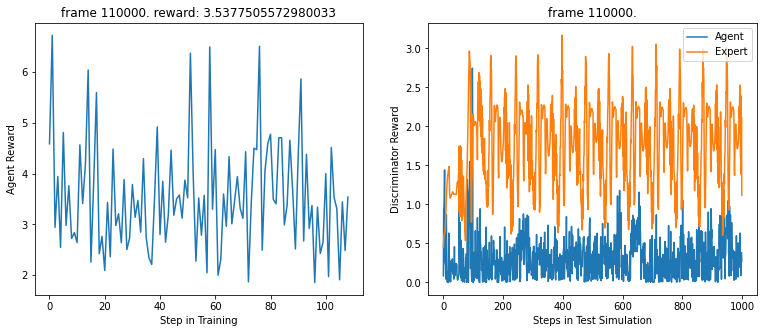

In [ ]:
ob_shape = list(env.observation_space.shape)
ac_shape = list(env.action_space.shape)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

ob = env.reset()

ppo = PPO(lr=lr, num_units=ppo_hidden_size)
discriminator = Discriminator(lr=lr, num_units=discriminator_hidden_size)

i_update = 0

while frame_idx < max_frames:
    i_update += 1
    
    values    = []
    obs    = []
    acs   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        ob = tf.reshape(tf.convert_to_tensor(ob), (1,11))
        ac = ppo.get_action(ob)
        ac = tf.reshape(tf.convert_to_tensor(ac), (3, 1))
        next_ob, _, done, _ = env.step(ac)
        reward = discriminator.get_reward(np.concatenate([ob, tf.transpose(ac)], axis=1))
        value = ppo.get_value(ob)
        values.append(value)
        rewards.append(reward)
        masks.append((1-done))

        obs.append(ob)
        acs.append(np.transpose(ac))

        ob = next_ob
        frame_idx += 1

        if frame_idx % 1000 == 0 and i_update > 1:
            test_reward = np.mean([test_env(ppo) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards, discriminator.get_reward(policy_ob_ac), 
                 discriminator.get_reward(expert_ob_ac))
    
    next_ob = tf.reshape(tf.convert_to_tensor(next_ob), (1,11))
    
    next_value = ppo.get_value(next_ob)
    returns = compute_gae(next_value, rewards, masks, values)

    returns = np.concatenate(returns)
    values = np.concatenate(values)
    obs = np.concatenate(obs)
    acs = np.concatenate(acs)
    advantages = returns - values
    
    # Policy Update
    if i_update % 3 == 0:
        ppo.update_policy()
        for _ in range(ppo_epochs):
            for ob_batch, ac_batch, return_batch, adv_batch in \
            ppo_iteration(mini_batch_size, obs, acs, returns, advantages):
                ppo.train_policy(ac_batch, ob_batch, adv_batch, return_batch)
    
    # Discriminator Update
    expert_samples = np.random.randint(0, mujoco_hopper_np['acs'].shape[1], 1)
    expert_ob_ac = np.concatenate([
        mujoco_hopper_np['obs'][expert_samples,:num_steps,:].reshape(num_steps,11),
        mujoco_hopper_np['acs'][expert_samples,:num_steps,:].reshape(num_steps,3)
    ],1)
    policy_ob_ac = np.concatenate([obs, acs], 1)
    discriminator.train_discriminator(np.concatenate([expert_ob_ac, policy_ob_ac], axis=0))